In [1]:
import os
import sys
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from skimage import data
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from visdom import Visdom

import torch
import torch.nn as nn
import torch.nn.init as init
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
from torchvision.utils import save_image
from torchsummary import summary

In [2]:
def init_params(model):
    for m in model.modules():
        if isinstance(m, nn.Conv2d):
            init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
        elif isinstance(m, nn.BatchNorm2d):
            init.constant_(m.weight, 1)
            init.constant_(m.bias, 0)
        elif isinstance(m, nn.Linear):
            init.constant_(m.bias, 0)

In [3]:
class Flatten(nn.Module):
    def __init__(self):
        super(Flatten, self).__init__()
    def forward(self, x):
        batch_size = x.shape[0]
        return x.view(batch_size, -1)

In [4]:
class CAE(nn.Module):
    def __init__(self):
        super(CAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 8, 3, stride=2, padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            #nn.Conv2d(32, 32, 3, stride=2, padding=1),
            #nn.BatchNorm2d(32),
            #nn.ReLU(True),
            #
            nn.Conv2d(8, 16, 3, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            #nn.Conv2d(64, 64, 3, stride=2, padding=1),
            #nn.BatchNorm2d(64),
            #nn.ReLU(True),
            #
            nn.Conv2d(16, 32, 3, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            #fc
            nn.Conv2d(32, 64, 28),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 28),
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            #nn.ConvTranspose2d(128, 128, 2, stride=2, padding=0),
            #nn.BatchNorm2d(128),
            #nn.ReLU(True),
            #fc
            nn.ConvTranspose2d(32, 16, 2, stride=2, padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            #nn.ConvTranspose2d(64, 64, 2, stride=2, padding=0),
            #nn.BatchNorm2d(64),
            #nn.ReLU(True),
            #
            nn.ConvTranspose2d(16, 8, 2, stride=2, padding=0),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(8, 3, 2, stride=2, padding=0),
            nn.Tanh()
        )
        
        
        
    def forward(self, x, indices=None):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    
cae = CAE()
init_params(cae)
cae.cuda()
summary(cae, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 8, 112, 112]             224
       BatchNorm2d-2          [-1, 8, 112, 112]              16
              ReLU-3          [-1, 8, 112, 112]               0
            Conv2d-4           [-1, 16, 56, 56]           1,168
       BatchNorm2d-5           [-1, 16, 56, 56]              32
              ReLU-6           [-1, 16, 56, 56]               0
            Conv2d-7           [-1, 32, 28, 28]           4,640
       BatchNorm2d-8           [-1, 32, 28, 28]              64
              ReLU-9           [-1, 32, 28, 28]               0
           Conv2d-10             [-1, 64, 1, 1]       1,605,696
      BatchNorm2d-11             [-1, 64, 1, 1]             128
             ReLU-12             [-1, 64, 1, 1]               0
  ConvTranspose2d-13           [-1, 32, 28, 28]       1,605,664
      BatchNorm2d-14           [-1, 32,

In [5]:
def to_img(x):
    x = 0.5*(x+1)
    x = x.clamp(0, 1)
    #x = x.view(x.size(0), 3, 224, 224)
    return x

In [6]:
normalize = transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
train_ds = datasets.ImageFolder(
    'dataset/normals_cut_224_pt/',
    transforms.Compose([
        #transforms.Resize(224),
        #transforms.RandomHorizontalFlip(),
        #transforms.RandomRotation(180),
        #transforms.RandomVerticalFlip(),
        transforms.ToTensor(),
        normalize,
    ])
)

train_loader = DataLoader(
    train_ds,
    batch_size=16,
    shuffle=True,
    num_workers=4,
    pin_memory=True
)

test_ds = datasets.ImageFolder(
    'dataset/normals_cut_224_pt/',
    transforms.Compose([
        #transforms.Resize(224),
        transforms.ToTensor(),
        normalize,
    ])
)

test_loader = DataLoader(
    test_ds,
    batch_size=16,
    shuffle=False,
    num_workers=4,
    pin_memory=True
)

In [7]:
torch.backends.cudnn.benchmark = True

In [8]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(cae.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 240, gamma=0.1)

In [9]:
train_loss_list = list()
for epoch in range(300):
    train_loss = 0
    
    cae.train()
    for i, (imgs, _) in enumerate(train_loader):
        imgs = imgs.cuda()
        
        outputs = cae(imgs)
        loss = criterion(outputs, imgs)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
    
    avg_train_loss = train_loss / len(train_loader.dataset)
    
    # visualize
    #viz.line(X=np.array([epoch]), Y=np.array([avg_train_loss]), win='loss', name='train_loss', update='append')
    
    print('epoch: {}, train_loss: {:.7f}'
          .format(epoch, avg_train_loss))
    
    if (epoch+1) % 20 == 0:
        pic = to_img(outputs.cpu().data[0])
        save_image(pic, f'./result/cae{epoch+1}.png', padding=0)
    
    scheduler.step()    
    

epoch: 0, train_loss: 0.0241840
epoch: 1, train_loss: 0.0214496
epoch: 2, train_loss: 0.0198283
epoch: 3, train_loss: 0.0179703
epoch: 4, train_loss: 0.0163460
epoch: 5, train_loss: 0.0147547
epoch: 6, train_loss: 0.0132305
epoch: 7, train_loss: 0.0117033
epoch: 8, train_loss: 0.0106732
epoch: 9, train_loss: 0.0094358
epoch: 10, train_loss: 0.0084835
epoch: 11, train_loss: 0.0077216
epoch: 12, train_loss: 0.0068254
epoch: 13, train_loss: 0.0062809
epoch: 14, train_loss: 0.0056830
epoch: 15, train_loss: 0.0051720
epoch: 16, train_loss: 0.0047850
epoch: 17, train_loss: 0.0043698
epoch: 18, train_loss: 0.0041769
epoch: 19, train_loss: 0.0038303
epoch: 20, train_loss: 0.0036275
epoch: 21, train_loss: 0.0034471
epoch: 22, train_loss: 0.0033176
epoch: 23, train_loss: 0.0031936
epoch: 24, train_loss: 0.0031447
epoch: 25, train_loss: 0.0029838
epoch: 26, train_loss: 0.0030771
epoch: 27, train_loss: 0.0028847
epoch: 28, train_loss: 0.0028263
epoch: 29, train_loss: 0.0026924
epoch: 30, train_los

epoch: 244, train_loss: 0.0011727
epoch: 245, train_loss: 0.0012059
epoch: 246, train_loss: 0.0011669
epoch: 247, train_loss: 0.0011401
epoch: 248, train_loss: 0.0012070
epoch: 249, train_loss: 0.0011300
epoch: 250, train_loss: 0.0011833
epoch: 251, train_loss: 0.0011105
epoch: 252, train_loss: 0.0011424
epoch: 253, train_loss: 0.0011428
epoch: 254, train_loss: 0.0011207
epoch: 255, train_loss: 0.0011300
epoch: 256, train_loss: 0.0011087
epoch: 257, train_loss: 0.0011321
epoch: 258, train_loss: 0.0011070
epoch: 259, train_loss: 0.0011068
epoch: 260, train_loss: 0.0010857
epoch: 261, train_loss: 0.0011573
epoch: 262, train_loss: 0.0011019
epoch: 263, train_loss: 0.0011351
epoch: 264, train_loss: 0.0011164
epoch: 265, train_loss: 0.0011321
epoch: 266, train_loss: 0.0011727
epoch: 267, train_loss: 0.0011228
epoch: 268, train_loss: 0.0011448
epoch: 269, train_loss: 0.0010832
epoch: 270, train_loss: 0.0010992
epoch: 271, train_loss: 0.0010889
epoch: 272, train_loss: 0.0010720
epoch: 273, tr

In [10]:
cae.eval()
z = list()
z_label = list()
for i, (imgs, labels) in enumerate(test_loader):
        imgs = imgs.cuda()
        features = cae.encoder(imgs).data.cpu().numpy()
        #features = np.reshape(len(features), -1)
        z.extend(features)
        z_label.extend(labels.numpy())
        
z = np.array(z).reshape(len(z), -1).astype(torch.dtype)
z_label = np.array(z_label, dtype=torch.dtype)
z.shape

(153, 64)

In [11]:
z

array([[0.047616489231586456, 0.6732140779495239, 0.0, ...,
        0.021483873948454857, 0.683312714099884, 0.6421659588813782],
       [0.040327075868844986, 0.0, 0.0, ..., 0.0, 0.3112429976463318,
        0.0],
       [0.9722404479980469, 0.0, 0.0013361427700147033, ..., 0.0,
        0.051557738333940506, 0.0],
       ...,
       [0.0, 0.0, 0.0, ..., 0.0, 0.0, 0.0],
       [0.0, 0.0, 0.0, ..., 0.0, 0.0, 0.0],
       [0.0, 0.0, 0.0, ..., 0.0, 0.0, 0.0]], dtype=object)

In [12]:
feature_ae = pd.DataFrame({'label': z_label})
feature_ae

,label
0,0
1,0
2,0
3,0
4,0
...,...
148,1
149,1
150,1
151,1


In [13]:
feature_ae['type'] = feature_ae['label'].apply(lambda x: 'a' if x == 0 else 'h')
color_code = {'a': '#FF0000', 'h': '#0000FF'}
feature_ae['color'] = feature_ae['type'].apply(lambda x: color_code[x])
feature_ae

,label,type,color
0,0,a,#FF0000
1,0,a,#FF0000
2,0,a,#FF0000
3,0,a,#FF0000
4,0,a,#FF0000
...,...,...,...
148,1,h,#0000FF
149,1,h,#0000FF
150,1,h,#0000FF
151,1,h,#0000FF


In [14]:
tsne_z = TSNE(n_components=2).fit_transform(z)
tsne_z.shape

(153, 2)

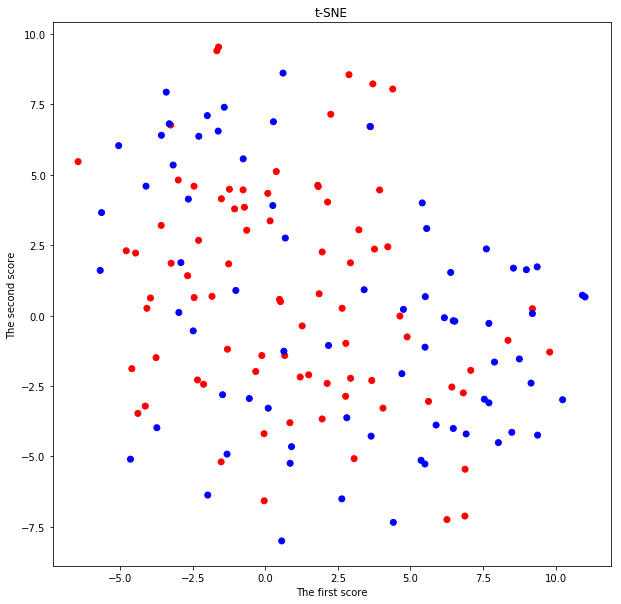

In [15]:
plt.figure(figsize=(10, 10))
plt.scatter(tsne_z[:, 0], tsne_z[:, 1], color=feature_ae['color'])
plt.title('t-SNE')
plt.xlabel('The first score')
plt.ylabel('The second score')
plt.savefig('result/tsne/cae.jpg')

In [16]:
pca_z = PCA(n_components=2).fit_transform(z)
pca_z.shape

(153, 2)

Text(0, 0.5, 'The second principal component score')

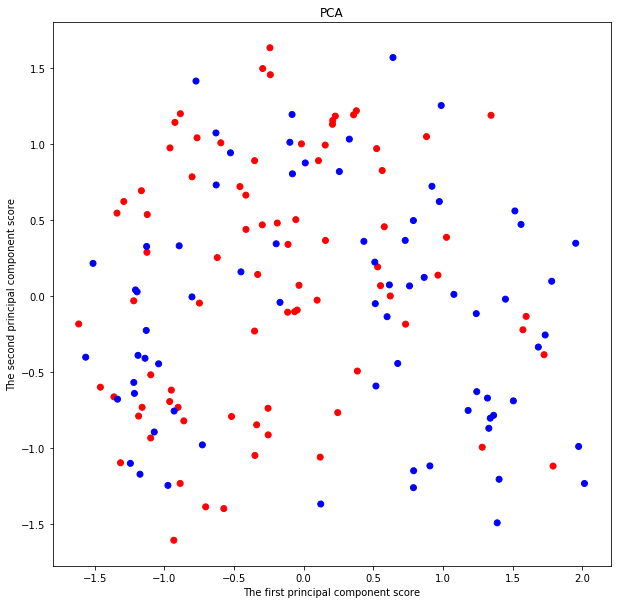

In [17]:
plt.figure(figsize=(10, 10))
plt.scatter(pca_z[:, 0], pca_z[:, 1], color=feature_ae['color'])
plt.title('PCA')
plt.xlabel('The first principal component score')
plt.ylabel('The second principal component score')

In [18]:
kmeans = KMeans(n_clusters=2).fit(z)

In [19]:
pred = kmeans.labels_
pred

array([0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0,
       1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1,
       1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0])

In [20]:

#Acc: 61.0
count = [{'a': 0, 'h': 0} for _ in range(2)]
for i, label in enumerate(pred):
    count[label][feature_ae['type'][i]] += 1
count

[{'a': 60, 'h': 32}, {'a': 21, 'h': 40}]